In [2]:
import polars as pl
import spacy
from multiprocessing import Pool
from tqdm import tqdm
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nlp = spacy.load("en_core_web_lg")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/justus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:


data = pl.read_csv("../../data/jazeera_qatar_fifa_2010-2023/articles.csv")
data_filtered = data

In [3]:
data = data_filtered

In [4]:
lazy_frame = pl.LazyFrame(data.select(["date", "title", "url", "paragraphs_text"])).with_columns(pl.col("paragraphs_text").map_elements(lambda x: [i.text for i in nlp(x).sents]).alias("sentence")).select(["title", "date", "url", "sentence"]).explode("sentence")

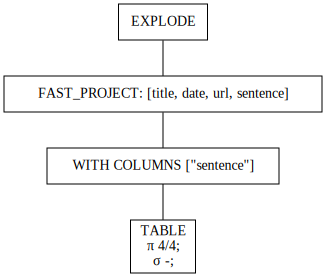

In [5]:
lazy_frame.show_graph()

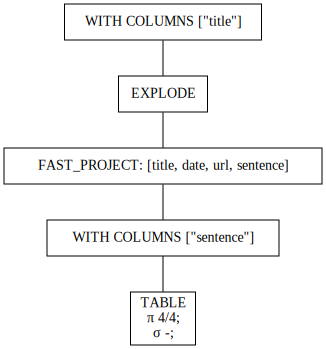

In [6]:
df = lazy_frame.with_columns(pl.col("title").str.split(" | ").map_elements(lambda splitlist: splitlist[0]))
df.show_graph()

In [7]:
df.sink_csv("../../data/jazeera_qatar_fifa_2010-2023/jazeera_sentences_sink_shortened_titles.csv")

In [8]:
df = pl.scan_csv("out/jazeera_sentences_sink_shortened_titles.csv")
df = df.with_columns(pl.col("sentence").str.to_lowercase().map_elements(lambda sent: " ".join([tok.text for tok in nlp(sent) if not tok.is_stop])))
df = df.with_columns(pl.col("sentence").map_elements(lambda sent: [ent.lemma_ for ent in nlp(sent).ents]).alias("entities"))
hist = df.select(pl.col("entities")).explode(pl.col("entities")).drop_nulls().group_by(pl.col("entities")).count().sort("count", descending=True)


In [9]:
sentences = pl.scan_csv("../../data/jazeera_qatar_fifa_2010-2023/jazeera_sentences_sink_shortened_titles.csv").collect()

sents_containing = hist.head(200).with_columns(
    pl.col("entities")
    .map_elements(lambda ent: sentences.select("sentence")
        .filter(pl.col("sentence").str.to_lowercase().str.contains(ent)))
        .map_elements(lambda df_: df_.to_numpy().tolist())
        .alias("sentences")
)

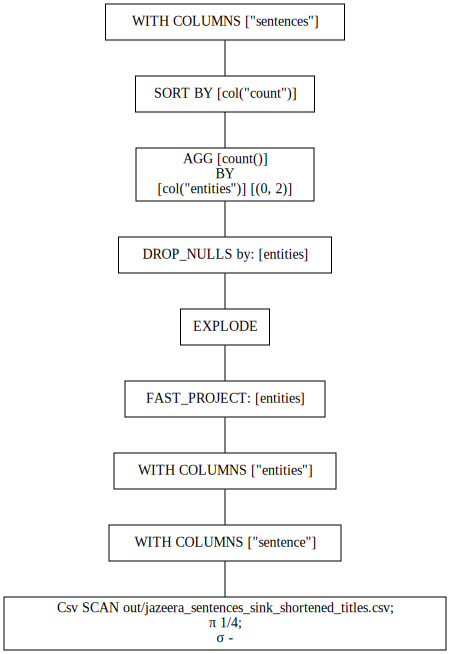

In [10]:
sents_containing.show_graph()

In [11]:
sid = SentimentIntensityAnalyzer()


sentiments = sents_containing.explode("sentences").explode("sentences").with_columns(pl.col("sentences").map_elements(lambda sent: sid.polarity_scores(sent)).alias("sentiment")).unnest("sentiment")
top_200_sentiments = sentiments.collect().group_by("entities").mean().sort("count", descending=True)

In [12]:
top_200_sentiments.write_csv("../../data/top_200_entity_sents.csv")
top_200_sentiments

entities,count,sentences,neg,neu,pos,compound
str,f64,str,f64,f64,f64,f64
"""qatar""",5581.0,null,0.051327,0.871437,0.077235,0.093202
"""al jazeera""",4596.0,null,0.020274,0.947274,0.032453,0.040993
"""english""",3198.0,null,0.009171,0.972256,0.018574,0.032813
"""fifa""",1685.0,null,0.046266,0.879515,0.074218,0.106352
"""second""",1376.0,null,0.05192,0.855024,0.093053,0.14968
"""saudi arabia""",1291.0,null,0.062685,0.858133,0.079174,0.062736
"""arab""",1253.0,null,0.05643,0.860789,0.082769,0.090735
"""argentina""",1240.0,null,0.04662,0.84314,0.110236,0.219186
"""brazil""",1163.0,null,0.047229,0.854287,0.098488,0.174088


## Pos Tagging and filtering

8

In [25]:
df = pl.read_csv("../../data/jazeera_qatar_fifa_2010-2023/articles.csv")

In [41]:
hist = dict()
articles = df.select("paragraphs_text").with_columns(pl.col("paragraphs_text").str.to_lowercase()).filter(pl.col("paragraphs_text").str.contains("fifa")).to_numpy()[:,0]
for doc in tqdm(articles):
    doc = nlp(doc)
    pos = [token.pos_ for token in doc]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    for noun in nouns:
    
        if noun not in hist:
            hist[noun] = 0
        hist[noun] += 1


100%|██████████| 916/916 [04:12<00:00,  3.63it/s]  


In [46]:
pl.DataFrame({"noun": list(hist.keys()), "count": list(hist.values())}).sort("count", descending=True).head(100)

noun,count
str,i64
"""world""",4631
"""cup""",3096
"""football""",2417
"""team""",1972
"""year""",1364
"""country""",1317
"""time""",1192
"""tournament""",1153
"""players""",1115


In [21]:
hist = {}
for sent, nouns in lf.select("nouns", "sentence").with_columns(pl.col("sentence").str.to_lowercase()).head(1000).collect().iter_rows():
    if "fifa" in sent: # Finding if this sentence is about FIFA
        for noun in nouns: # Updating co-occurence hist
            if noun not in hist:
                hist[noun] = 0
            else:
                hist[noun] += 1
            

KeyboardInterrupt: 

In [20]:
hist

{}